# 测试 mesh_geodesic.py 中的函数

本notebook用于测试 `tomopanda.core.mesh_geodesic` 模块中的各种函数。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os

# 添加项目路径
sys.path.append('/home/muwang/Documents/GitHub/TomoPANDA')

# 导入mesh_geodesic模块
from tomopanda.core.mesh_geodesic import (
    MeshGeodesicSampler, 
    generate_synthetic_mask
)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 1. 合成膜
## 1.1 生成膜结构


In [2]:
# 选择数据源
USE_SYNTHETIC = True  # 设置为True使用合成数据，False使用MRC文件
mrc_path = "path/to/your/file.mrc"  # 请修改为实际路径


if USE_SYNTHETIC:
    # 选项1：生成合成球形膜结构
    print("使用合成球形膜结构...")
    box_size = 256
    sphere_radius = 64  # 直径128，半径64
    membrane_thickness = 6
    center = (128, 128, 128)

    mask = generate_synthetic_mask(
        shape=(box_size, box_size, box_size),
        center=center,
        radius=sphere_radius,
        membrane_thickness=membrane_thickness
    )
    
    print(f"膜结构形状: {mask.shape}")
    print(f"膜区域像素数量: {np.sum(mask > 0)}")
    print(f"膜厚度: {membrane_thickness} 像素")
    print(f"球半径: {sphere_radius} 像素")
    
else:
    # 选项2：读取MRC文件
    print("使用MRC文件...")
    from tomopanda.utils.mrc_utils import MRCReader
    
    # 修改这里的路径为你的MRC文件路径
    mrc_path = mrc_path  # 请修改为实际路径
    
    try:
        mask, metadata = MRCReader.read_mrc(mrc_path)
        print(f"成功读取MRC文件: {mrc_path}")
        print(f"膜结构形状: {mask.shape}")
        print(f"膜区域像素数量: {np.sum(mask > 0)}")
        if metadata:
            print(f"MRC元数据: {metadata}")
    except Exception as e:
        print(f"读取MRC文件失败: {e}")
        print("回退到合成数据...")
        
        # 回退到合成数据
        box_size = 256
        sphere_radius = 64
        membrane_thickness = 6
        center = (128, 128, 128)
        
        mask = generate_synthetic_mask(
            shape=(box_size, box_size, box_size),
            center=center,
            radius=sphere_radius,
            membrane_thickness=membrane_thickness
        )
        print(f"使用合成数据，膜结构形状: {mask.shape}")




使用合成球形膜结构...
膜结构形状: (256, 256, 256)
膜区域像素数量: 281514
膜厚度: 6 像素
球半径: 64 像素


## 1.2 执行 create_signed_distance_field


In [3]:
# 创建采样器实例
sampler = MeshGeodesicSampler(
    smoothing_sigma=1.5,
    expected_particle_size=5,
    random_seed=42
)

# 计算符号距离场
print("计算符号距离场...")
phi = sampler.create_signed_distance_field(mask, target_resolution=1.0)

print(f"SDF形状: {phi.shape}")
print(f"φ=0 的像素数量: {np.sum(phi == 0)}")
print(f"φ 的最小值: {np.min(phi):.3f}")
print(f"φ 的最大值: {np.max(phi):.3f}")
print(f"φ 的平均值: {np.mean(phi):.3f}")


计算符号距离场...
SDF形状: (256, 256, 256)
φ=0 的像素数量: 141272
φ 的最小值: 0.000
φ 的最大值: 161.802
φ 的平均值: 64.378


## 1.3 可视化结果


φ=0 pixels - XY: 1336, XZ: 1336, YZ: 1336


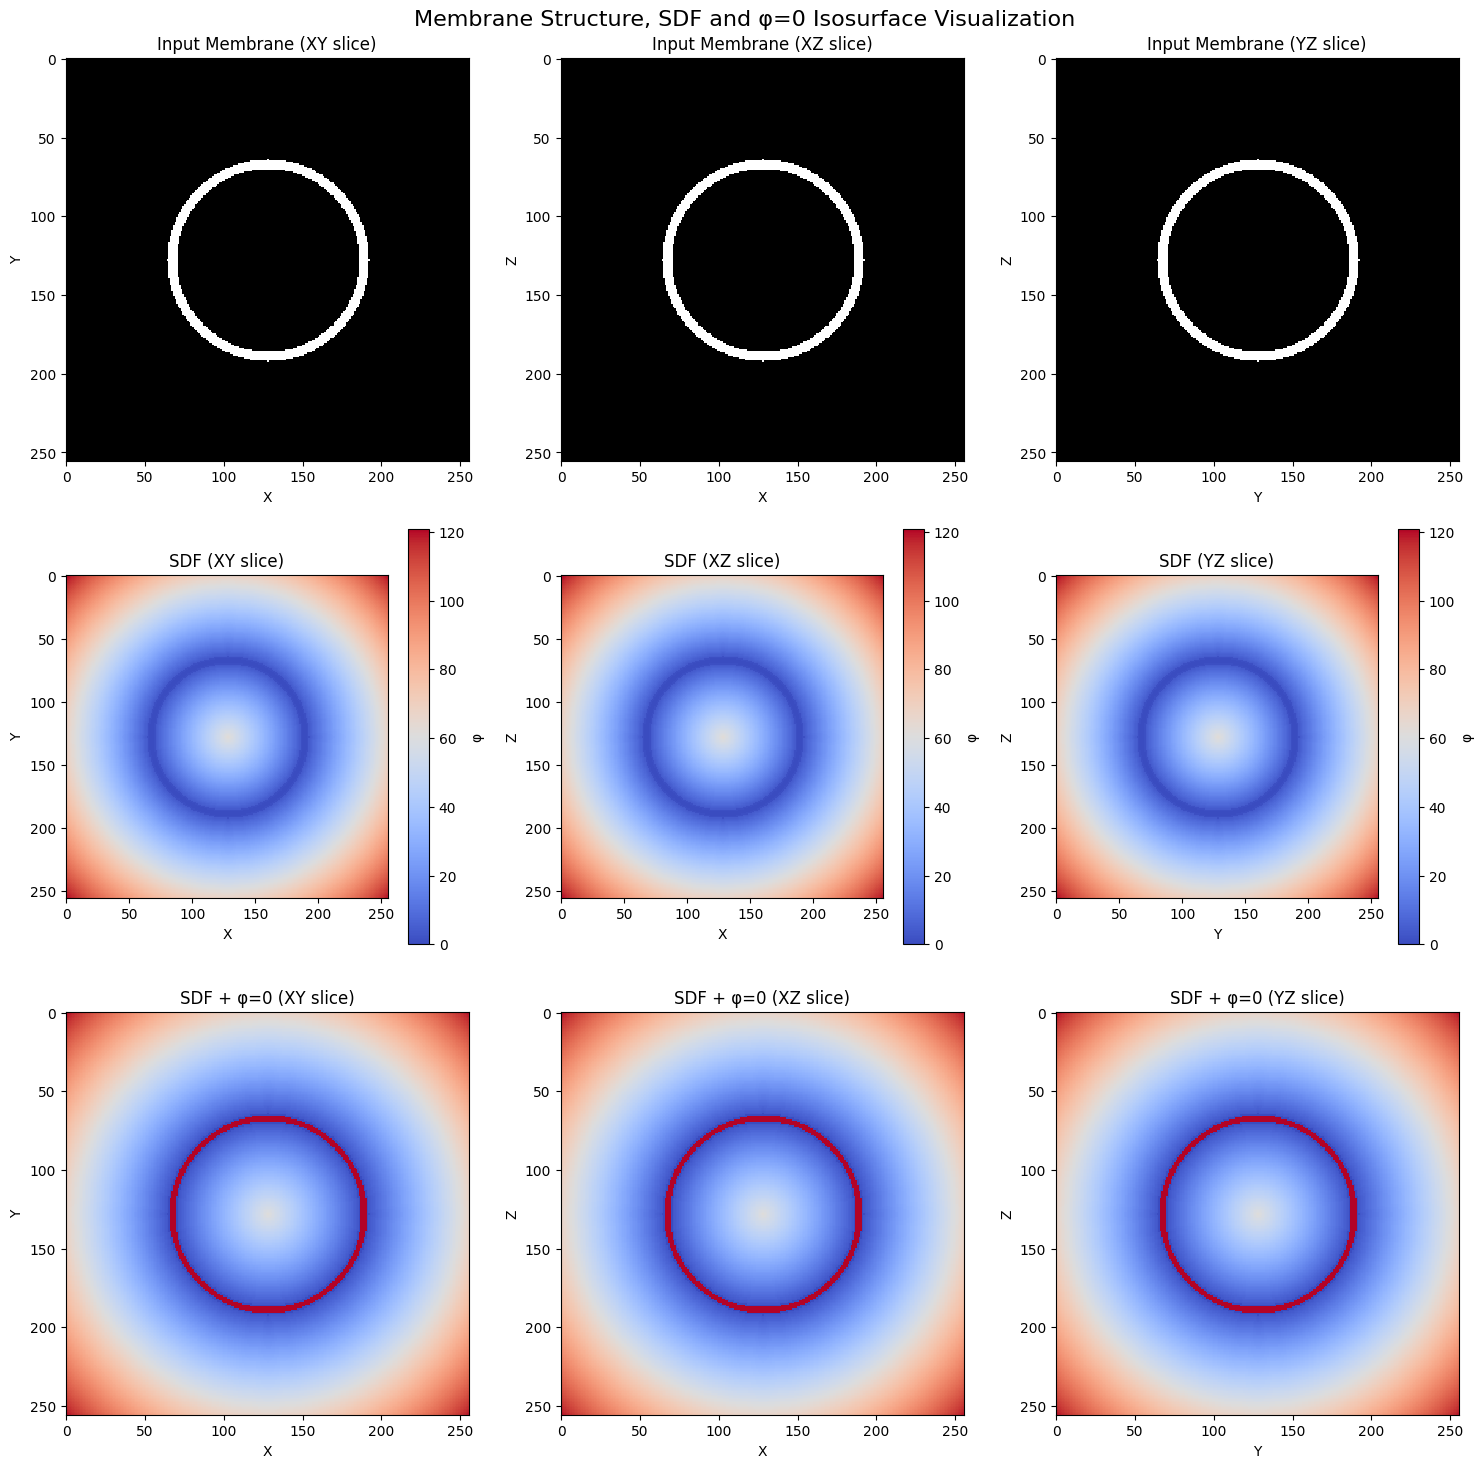


=== Analysis Results ===
Membrane pixels: 281514
φ=0 pixels: 141272
φ value range: [0.000, 161.802]
φ=0 ratio: 0.84%


In [4]:
# ==================== 输入数据 ====================
# 输入：3D数组 (mask, phi)
input_mask = mask      # 膜结构掩码
input_phi = phi        # 符号距离场

# ==================== 可视化函数 ====================
def visualize_3d_sdf(mask, phi, title="Membrane Structure, SDF and φ=0 Isosurface Visualization"):
    """
    可视化3D膜结构、SDF和φ=0等值面
    
    Args:
        mask: 3D膜结构掩码 (z, y, x)
        phi: 3D符号距离场 (z, y, x)
        title: 图表标题
    """
    # 创建3x3子图
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(title, fontsize=16)
    
    # 选择中心切片
    z_center = mask.shape[0] // 2
    y_center = mask.shape[1] // 2  
    x_center = mask.shape[2] // 2
    
    # 第一行：输入膜结构
    axes[0, 0].imshow(mask[z_center, :, :], cmap='gray', interpolation='nearest')
    axes[0, 0].set_title('Input Membrane (XY slice)')
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('Y')
    
    axes[0, 1].imshow(mask[:, y_center, :], cmap='gray', interpolation='nearest')
    axes[0, 1].set_title('Input Membrane (XZ slice)')
    axes[0, 1].set_xlabel('X')
    axes[0, 1].set_ylabel('Z')
    
    axes[0, 2].imshow(mask[:, :, x_center], cmap='gray', interpolation='nearest')
    axes[0, 2].set_title('Input Membrane (YZ slice)')
    axes[0, 2].set_xlabel('Y')
    axes[0, 2].set_ylabel('Z')
    
    # 第二行：SDF
    im1 = axes[1, 0].imshow(phi[z_center, :, :], cmap='coolwarm', interpolation='nearest')
    axes[1, 0].set_title('SDF (XY slice)')
    axes[1, 0].set_xlabel('X')
    axes[1, 0].set_ylabel('Y')
    plt.colorbar(im1, ax=axes[1, 0], label='φ')
    
    im2 = axes[1, 1].imshow(phi[:, y_center, :], cmap='coolwarm', interpolation='nearest')
    axes[1, 1].set_title('SDF (XZ slice)')
    axes[1, 1].set_xlabel('X')
    axes[1, 1].set_ylabel('Z')
    plt.colorbar(im2, ax=axes[1, 1], label='φ')
    
    im3 = axes[1, 2].imshow(phi[:, :, x_center], cmap='coolwarm', interpolation='nearest')
    axes[1, 2].set_title('SDF (YZ slice)')
    axes[1, 2].set_xlabel('Y')
    axes[1, 2].set_ylabel('Z')
    plt.colorbar(im3, ax=axes[1, 2], label='φ')
    
    # 第三行：SDF + φ=0红色标记
    phi_xy = phi[z_center, :, :].copy()
    phi_xz = phi[:, y_center, :].copy()
    phi_yz = phi[:, :, x_center].copy()
    
    # 将φ=0的像素标记为红色
    phi_zero_xy = (phi[z_center, :, :] == 0)
    phi_zero_xz = (phi[:, y_center, :] == 0)
    phi_zero_yz = (phi[:, :, x_center] == 0)
    
    print(f"φ=0 pixels - XY: {np.sum(phi_zero_xy)}, XZ: {np.sum(phi_zero_xz)}, YZ: {np.sum(phi_zero_yz)}")
    
    # 显示SDF，φ=0区域用红色覆盖（所见即所得）
    # 创建混合图像：SDF背景 + φ=0红色覆盖
    phi_xy_mixed = phi_xy.copy()
    phi_xz_mixed = phi_xz.copy()
    phi_yz_mixed = phi_yz.copy()
    
    # 将φ=0的像素设置为一个很大的值，这样在coolwarm色彩映射中会显示为红色
    phi_xy_mixed[phi_zero_xy] = np.max(phi_xy) + 1
    phi_xz_mixed[phi_zero_xz] = np.max(phi_xz) + 1
    phi_yz_mixed[phi_zero_yz] = np.max(phi_yz) + 1
    
    # 显示混合后的图像
    axes[2, 0].imshow(phi_xy_mixed, cmap='coolwarm', interpolation='nearest')
    axes[2, 0].set_title('SDF + φ=0 (XY slice)')
    axes[2, 0].set_xlabel('X')
    axes[2, 0].set_ylabel('Y')
    
    axes[2, 1].imshow(phi_xz_mixed, cmap='coolwarm', interpolation='nearest')
    axes[2, 1].set_title('SDF + φ=0 (XZ slice)')
    axes[2, 1].set_xlabel('X')
    axes[2, 1].set_ylabel('Z')
    
    axes[2, 2].imshow(phi_yz_mixed, cmap='coolwarm', interpolation='nearest')
    axes[2, 2].set_title('SDF + φ=0 (YZ slice)')
    axes[2, 2].set_xlabel('Y')
    axes[2, 2].set_ylabel('Z')
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n=== Analysis Results ===")
    print(f"Membrane pixels: {np.sum(mask > 0)}")
    print(f"φ=0 pixels: {np.sum(phi == 0)}")
    print(f"φ value range: [{np.min(phi):.3f}, {np.max(phi):.3f}]")
    print(f"φ=0 ratio: {np.sum(phi == 0)/phi.size*100:.2f}%")

# ==================== 执行可视化 ====================
visualize_3d_sdf(input_mask, input_phi)


In [5]:
# 3D可视化 φ=0 像素 - 可交互视图

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def visualize_phi_zero_3d(phi, title="φ=0 像素的3D可视化"):
    """
    使用可交互的3D视图展示φ=0的像素
    
    Args:
        phi: 符号距离场数组
        title: 图表标题
    """
    print(f"φ数组形状: {phi.shape}")
    print(f"φ=0像素数量: {np.sum(phi == 0)}")
    print(f"φ=0像素比例: {np.sum(phi == 0)/phi.size*100:.4f}%")
    
    # 找到所有φ=0的像素坐标
    phi_zero_coords = np.where(phi == 0)
    z_coords, y_coords, x_coords = phi_zero_coords
    
    print(f"φ=0像素坐标数量: {len(z_coords)}")
    
    if len(z_coords) == 0:
        print("没有找到φ=0的像素")
        return
    
    # 创建可交互的3D散点图
    fig = go.Figure(data=go.Scatter3d(
        x=x_coords,
        y=y_coords, 
        z=z_coords,
        mode='markers',
        marker=dict(
            size=2,  # 点的大小
            color='red',  # 红色
            opacity=0.8,
            line=dict(width=0)
        ),
        name='φ=0 像素',
        hovertemplate='<b>φ=0 像素</b><br>' +
                     'X: %{x}<br>' +
                     'Y: %{y}<br>' +
                     'Z: %{z}<extra></extra>'
    ))
    
    # 设置布局
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            font=dict(size=16)
        ),
        scene=dict(
            xaxis_title='X 坐标',
            yaxis_title='Y 坐标', 
            zaxis_title='Z 坐标',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            ),
            aspectmode='data'  # 保持坐标轴比例
        ),
        width=800,
        height=600,
        showlegend=True
    )
    
    # 显示图表
    fig.show()
    
    # 额外信息：显示φ=0像素的分布统计
    print(f"\n=== φ=0 像素分布统计 ===")
    print(f"X坐标范围: [{np.min(x_coords)}, {np.max(x_coords)}]")
    print(f"Y坐标范围: [{np.min(y_coords)}, {np.max(y_coords)}]")
    print(f"Z坐标范围: [{np.min(z_coords)}, {np.max(z_coords)}]")
    
    # 计算φ=0像素的密度分布
    z_density = np.bincount(z_coords)
    y_density = np.bincount(y_coords)
    x_density = np.bincount(x_coords)
    
    print(f"Z方向φ=0像素密度: 最大={np.max(z_density)}, 平均={np.mean(z_density):.2f}")
    print(f"Y方向φ=0像素密度: 最大={np.max(y_density)}, 平均={np.mean(y_density):.2f}")
    print(f"X方向φ=0像素密度: 最大={np.max(x_density)}, 平均={np.mean(x_density):.2f}")



# 执行可视化
if 'phi' in locals():
    print("=== 3D可视化 φ=0 像素 ===")
    visualize_phi_zero_3d(phi, "φ=0 像素的3D可视化")
    

else:
    print("未找到 phi 变量，请先运行前面的计算步骤")

=== 3D可视化 φ=0 像素 ===
φ数组形状: (256, 256, 256)
φ=0像素数量: 141272
φ=0像素比例: 0.8420%
φ=0像素坐标数量: 141272



=== φ=0 像素分布统计 ===
X坐标范围: [66, 190]
Y坐标范围: [66, 190]
Z坐标范围: [66, 190]
Z方向φ=0像素密度: 最大=1389, 平均=739.64
Y方向φ=0像素密度: 最大=1389, 平均=739.64
X方向φ=0像素密度: 最大=1389, 平均=739.64


## 1.4 test extract_mesh_from_sdf

In [12]:
# 测试 extract_mesh_from_sdf 函数

# 已有 sampler, phi, mask, 保持数据流连贯，直接调用 extract_mesh_from_sdf
print("从SDF中提取三角网格（marching cubes）...")
mesh = sampler.extract_mesh_from_sdf(phi)

print(f"提取网格完成！")
print(f"网格顶点数量: {len(mesh.vertices)}")
print(f"网格三角面数量: {len(mesh.triangles)}")

# 可选：简单可视化网格（如果是在notebook/jupyter，可用open3d）
try:
    import open3d as o3d
    o3d.visualization.draw_geometries([mesh])
except Exception as e:
    print("Open3D 可视化失败：", e)

从SDF中提取三角网格（marching cubes）...
开始法向量定向，面数: 105288
法向量定向完成，耗时: 0.11秒
提取网格完成！
网格顶点数量: 61107
网格三角面数量: 105288


In [ ]:

a


# 2.real MRC mask data from membrain
## 2.1 导入数据

In [7]:
# 选择数据源
USE_SYNTHETIC = False  # 设置为True使用合成数据，False使用MRC文件
mrc_path = '/home/muwang/Documents/projects/IR/20230518IR_mCherry/memseg_output_frames1_2_10A/rec_pinkss_MGS002_T2_ts_002_px10_MemBrain_seg_v10_beta.ckpt_segmented.mrc'  # 请修改为实际路径


if USE_SYNTHETIC:
    # 选项1：生成合成球形膜结构
    print("使用合成球形膜结构...")
    box_size = 256
    sphere_radius = 64  # 直径128，半径64
    membrane_thickness = 6
    center = (128, 128, 128)

    mask = generate_synthetic_mask(
        shape=(box_size, box_size, box_size),
        center=center,
        radius=sphere_radius,
        membrane_thickness=membrane_thickness
    )
    
    print(f"膜结构形状: {mask.shape}")
    print(f"膜区域像素数量: {np.sum(mask > 0)}")
    print(f"膜厚度: {membrane_thickness} 像素")
    print(f"球半径: {sphere_radius} 像素")
    
else:
    # 选项2：读取MRC文件
    print("使用MRC文件...")
    from tomopanda.utils.mrc_utils import MRCReader
    
    # 修改这里的路径为你的MRC文件路径
    mrc_path = mrc_path  # 请修改为实际路径
    
    try:
        mask, metadata = MRCReader.read_mrc(mrc_path)
        print(f"成功读取MRC文件: {mrc_path}")
        print(f"膜结构形状: {mask.shape}")
        print(f"膜区域像素数量: {np.sum(mask > 0)}")
        if metadata:
            print(f"MRC元数据: {metadata}")
    except Exception as e:
        print(f"读取MRC文件失败: {e}")
        print("回退到合成数据...")
        
        # 回退到合成数据
        box_size = 256
        sphere_radius = 64
        membrane_thickness = 6
        center = (128, 128, 128)
        
        mask = generate_synthetic_mask(
            shape=(box_size, box_size, box_size),
            center=center,
            radius=sphere_radius,
            membrane_thickness=membrane_thickness
        )
        print(f"使用合成数据，膜结构形状: {mask.shape}")


使用MRC文件...
成功读取MRC文件: /home/muwang/Documents/projects/IR/20230518IR_mCherry/memseg_output_frames1_2_10A/rec_pinkss_MGS002_T2_ts_002_px10_MemBrain_seg_v10_beta.ckpt_segmented.mrc
膜结构形状: (335, 671, 671)
膜区域像素数量: 2009848
MRC元数据: {'shape': (335, 671, 671), 'dtype': dtype('int8'), 'voxel_size': rec.array((10., 10., 10.),
          dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')]), 'origin': rec.array((0., 0., 0.),
          dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')]), 'cell_angles': rec.array((6710., 6710., 3350.),
          dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')]), 'cell_dimensions': rec.array((90., 90., 90.),
          dtype=[('alpha', '<f4'), ('beta', '<f4'), ('gamma', '<f4')]), 'spacegroup': array(1, dtype=int32), 'mode': array(0, dtype=int32), 'nx': array(671, dtype=int32), 'ny': array(671, dtype=int32), 'nz': array(335, dtype=int32), 'mx': array(671, dtype=int32), 'my': array(671, dtype=int32), 'mz': array(335, dtype=int32), 'xlen': array(6710., dtype=float32), 'ylen': 

## 2.2 执行create_signed_distance_field

In [8]:
# 创建采样器实例
sampler = MeshGeodesicSampler(
    smoothing_sigma=1.5,
    expected_particle_size=20,
    random_seed=42
)

# 计算符号距离场
print("计算符号距离场...")
phi = sampler.create_signed_distance_field(mask, target_resolution=1.0)

print(f"SDF形状: {phi.shape}")
print(f"φ=0 的像素数量: {np.sum(phi == 0)}")
print(f"φ 的最小值: {np.min(phi):.3f}")
print(f"φ 的最大值: {np.max(phi):.3f}")
print(f"φ 的平均值: {np.mean(phi):.3f}")


计算符号距离场...


SDF形状: (335, 671, 671)
φ=0 的像素数量: 65826
φ 的最小值: 0.000
φ 的最大值: 233.612
φ 的平均值: 73.284


## 2.3 可视化

φ=0 pixels - XY: 237, XZ: 11, YZ: 6


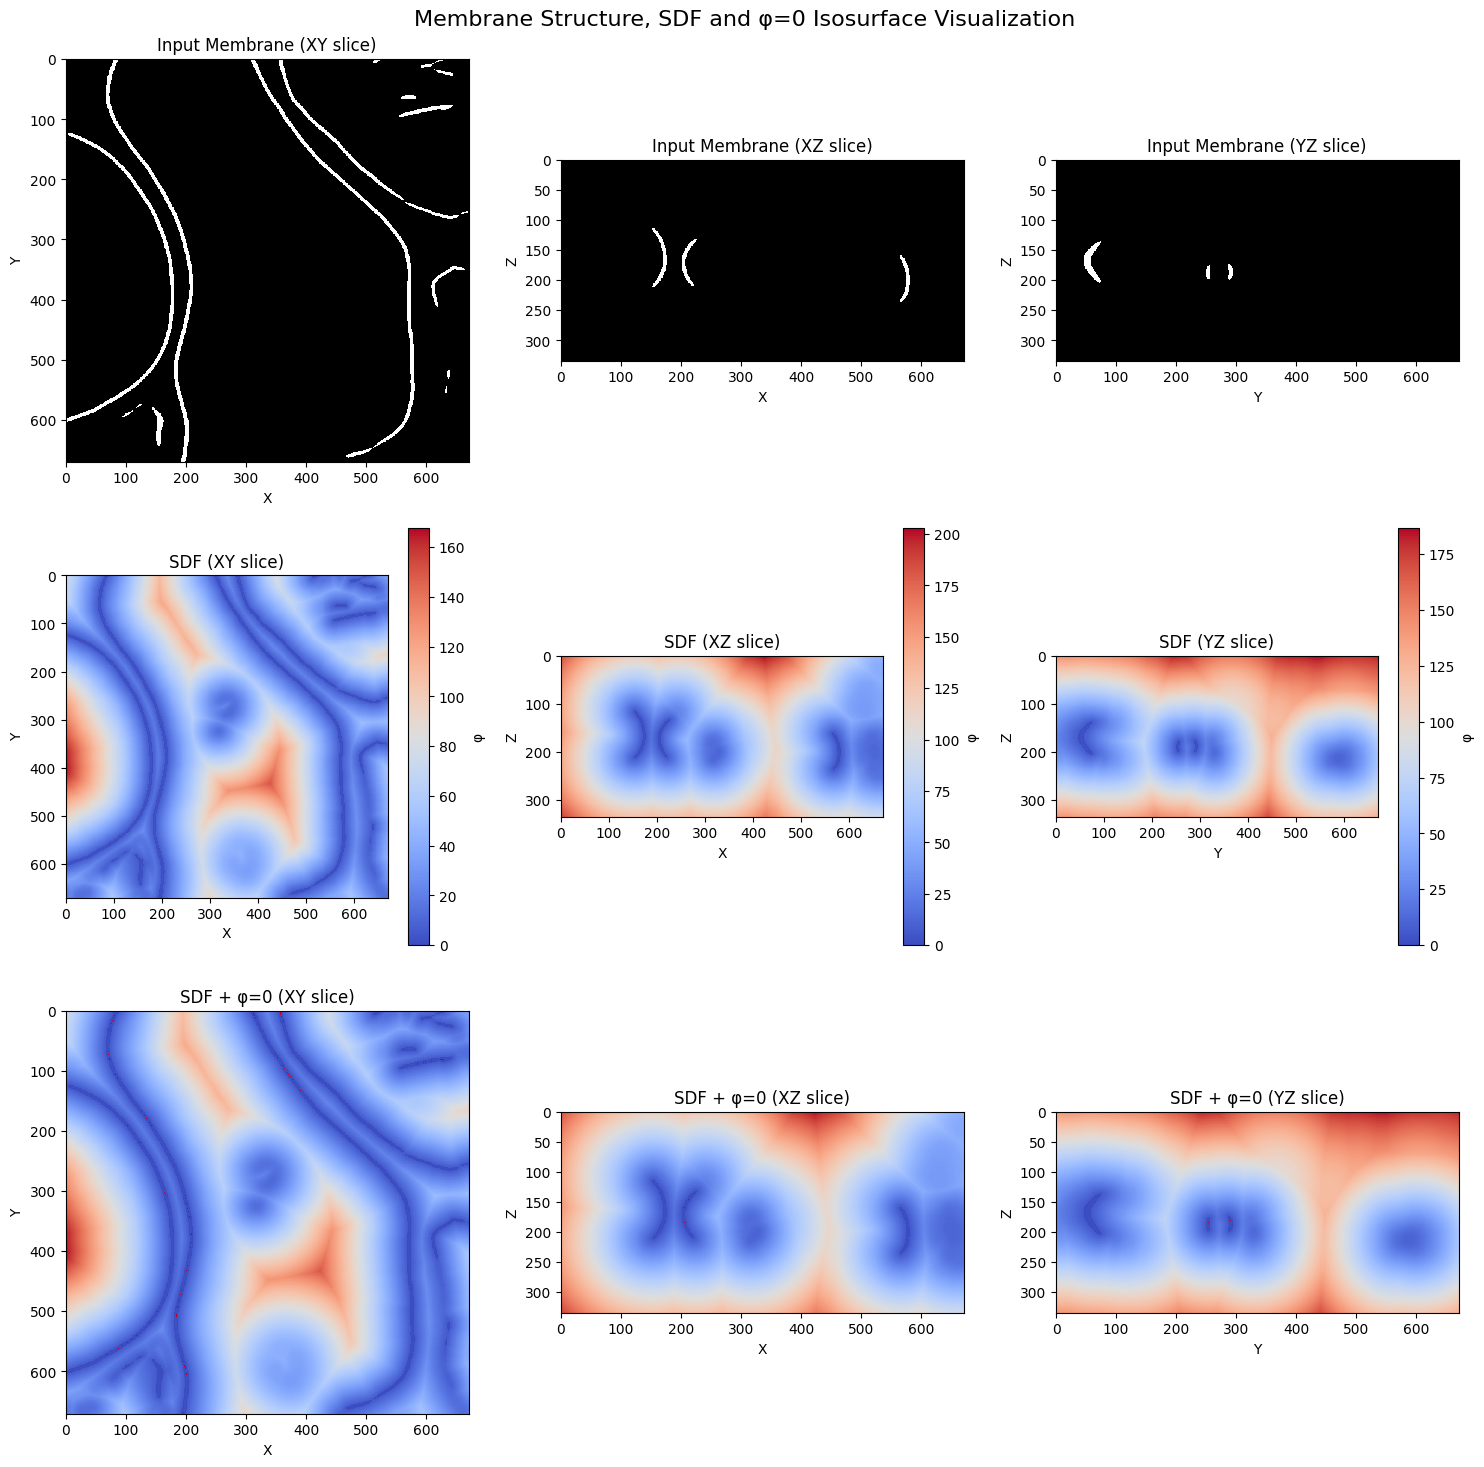


=== Analysis Results ===
Membrane pixels: 2009848
φ=0 pixels: 65826
φ value range: [0.000, 233.612]
φ=0 ratio: 0.04%


In [9]:
# ==================== 输入数据 ====================
# 输入：3D数组 (mask, phi)
input_mask = mask      # 膜结构掩码
input_phi = phi        # 符号距离场

# ==================== 可视化函数 ====================

visualize_3d_sdf(input_mask, input_phi)

## 2.4 phi 存储为mrc文件

In [10]:
# 保存 φ 符号距离场到 MRC 文件

import os
from tomopanda.utils.mrc_utils import MRCReader, MRCWriter

def save_phi_to_mrc(mrc_path, phi, output_dir="output"):
    """
    将 φ 符号距离场保存为新的 MRC 文件
    
    Args:
        mrc_path: 输入 MRC 文件路径
        phi: 符号距离场数组
        output_dir: 输出目录
    """
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)
    
    # 读取原始 MRC 文件的 header 信息
    print(f"读取原始 MRC 文件: {mrc_path}")
    try:
        original_data, metadata = MRCReader.read_mrc(mrc_path)
        print(f"原始文件形状: {original_data.shape}")
        print(f"原始文件元数据: {metadata}")
    except Exception as e:
        print(f"读取原始 MRC 文件失败: {e}")
        return None
    
    # 显示 φ 数组信息
    print(f"φ 数组形状: {phi.shape}")
    print(f"φ 数组数据类型: {phi.dtype}")
    print(f"φ 最小值: {np.min(phi):.6f}")
    print(f"φ 最大值: {np.max(phi):.6f}")
    print(f"φ 平均值: {np.mean(phi):.6f}")
    print(f"φ=0 像素数量: {np.sum(phi == 0)}")
    print(f"φ=0 像素比例: {np.sum(phi == 0)/phi.size*100:.4f}%")
    
    # 验证 φ 数组
    assert phi.ndim == 3, f"φ 数组必须是3D，当前维度: {phi.ndim}"
    assert phi.shape == original_data.shape, f"φ 数组形状与原始数据不匹配: {phi.shape} vs {original_data.shape}"
    print("✓ φ 数组验证通过")
    
    # 生成输出文件名
    base_name = os.path.splitext(os.path.basename(mrc_path))[0]
    output_filename = f"{base_name}_phi_sdf.mrc"
    output_path = os.path.join(output_dir, output_filename)
    
    # 保存 φ 数组到 MRC 文件，使用原始文件的 header 信息
    print(f"保存 φ 符号距离场到: {output_path}")
    try:
        MRCWriter.write_mrc(
            phi, 
            output_path,
            metadata=metadata
        )
        print(f"成功保存 φ 符号距离场文件: {output_path}")
        return output_path
    except Exception as e:
        print(f"保存文件失败: {e}")
        return None

# 执行保存
if 'phi' in locals() and 'mask' in locals():
    # 使用当前计算得到的 phi 和 mask
    print("使用当前计算得到的 phi 和 mask...")
    
    # 如果有 mrc_path 变量，使用它；否则使用默认路径
    if 'mrc_path' in locals():
        input_mrc_path = mrc_path
    else:
        # 如果没有 mrc_path，提示用户输入
        input_mrc_path = input("请输入 MRC 文件路径: ").strip()
        if not input_mrc_path:
            print("未提供 MRC 文件路径，跳过保存操作")
            input_mrc_path = None
    
    if input_mrc_path and os.path.exists(input_mrc_path):
        output_file = save_phi_to_mrc(input_mrc_path, phi)
        if output_file:
            print(f"\n=== 保存完成 ===")
            print(f"输出文件: {output_file}")
            print(f"文件大小: {os.path.getsize(output_file)} bytes")
            
            # 验证保存的文件
            try:
                saved_data, saved_metadata = MRCReader.read_mrc(output_file)
                print(f"验证保存的文件:")
                print(f"  形状: {saved_data.shape}")
                print(f"  数据类型: {saved_data.dtype}")
                print(f"  数值范围: [{np.min(saved_data):.6f}, {np.max(saved_data):.6f}]")
                print(f"  与原始φ数组是否相同: {np.allclose(saved_data, phi)}")
            except Exception as e:
                print(f"验证保存文件时出错: {e}")
    else:
        print("MRC 文件路径无效或文件不存在")
else:
    print("未找到 phi 变量，请先运行前面的计算步骤")


使用当前计算得到的 phi 和 mask...
读取原始 MRC 文件: /home/muwang/Documents/projects/IR/20230518IR_mCherry/memseg_output_frames1_2_10A/rec_pinkss_MGS002_T2_ts_002_px10_MemBrain_seg_v10_beta.ckpt_segmented.mrc
原始文件形状: (335, 671, 671)
原始文件元数据: {'shape': (335, 671, 671), 'dtype': dtype('int8'), 'voxel_size': rec.array((10., 10., 10.),
          dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')]), 'origin': rec.array((0., 0., 0.),
          dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')]), 'cell_angles': rec.array((6710., 6710., 3350.),
          dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')]), 'cell_dimensions': rec.array((90., 90., 90.),
          dtype=[('alpha', '<f4'), ('beta', '<f4'), ('gamma', '<f4')]), 'spacegroup': array(1, dtype=int32), 'mode': array(0, dtype=int32), 'nx': array(671, dtype=int32), 'ny': array(671, dtype=int32), 'nz': array(335, dtype=int32), 'mx': array(671, dtype=int32), 'my': array(671, dtype=int32), 'mz': array(335, dtype=int32), 'xlen': array(6710., dtype=float32), 'ylen': 

/home/muwang/miniforge3/envs/tomopanda/lib/python3.10/site-packages/mrcfile/mrcfile.py:150: RuntimeWarning:

MRC file is 452492205 bytes larger than expected



  与原始φ数组是否相同: False


In [11]:
# 3D可视化 φ=0 像素 - 可交互视图

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def visualize_phi_zero_3d(phi, title="φ=0 像素的3D可视化"):
    """
    使用可交互的3D视图展示φ=0的像素
    
    Args:
        phi: 符号距离场数组
        title: 图表标题
    """
    print(f"φ数组形状: {phi.shape}")
    print(f"φ=0像素数量: {np.sum(phi == 0)}")
    print(f"φ=0像素比例: {np.sum(phi == 0)/phi.size*100:.4f}%")
    
    # 找到所有φ=0的像素坐标
    phi_zero_coords = np.where(phi == 0)
    z_coords, y_coords, x_coords = phi_zero_coords
    
    print(f"φ=0像素坐标数量: {len(z_coords)}")
    
    if len(z_coords) == 0:
        print("没有找到φ=0的像素")
        return
    
    # 创建可交互的3D散点图
    fig = go.Figure(data=go.Scatter3d(
        x=x_coords,
        y=y_coords, 
        z=z_coords,
        mode='markers',
        marker=dict(
            size=2,  # 点的大小
            color='red',  # 红色
            opacity=0.8,
            line=dict(width=0)
        ),
        name='φ=0 像素',
        hovertemplate='<b>φ=0 像素</b><br>' +
                     'X: %{x}<br>' +
                     'Y: %{y}<br>' +
                     'Z: %{z}<extra></extra>'
    ))
    
    # 设置布局
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            font=dict(size=16)
        ),
        scene=dict(
            xaxis_title='X 坐标',
            yaxis_title='Y 坐标', 
            zaxis_title='Z 坐标',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            ),
            aspectmode='data'  # 保持坐标轴比例
        ),
        width=800,
        height=600,
        showlegend=True
    )
    
    # 显示图表
    fig.show()
    
    # 额外信息：显示φ=0像素的分布统计
    print(f"\n=== φ=0 像素分布统计 ===")
    print(f"X坐标范围: [{np.min(x_coords)}, {np.max(x_coords)}]")
    print(f"Y坐标范围: [{np.min(y_coords)}, {np.max(y_coords)}]")
    print(f"Z坐标范围: [{np.min(z_coords)}, {np.max(z_coords)}]")
    
    # 计算φ=0像素的密度分布
    z_density = np.bincount(z_coords)
    y_density = np.bincount(y_coords)
    x_density = np.bincount(x_coords)
    
    print(f"Z方向φ=0像素密度: 最大={np.max(z_density)}, 平均={np.mean(z_density):.2f}")
    print(f"Y方向φ=0像素密度: 最大={np.max(y_density)}, 平均={np.mean(y_density):.2f}")
    print(f"X方向φ=0像素密度: 最大={np.max(x_density)}, 平均={np.mean(x_density):.2f}")



# 执行可视化
if 'phi' in locals():
    print("=== 3D可视化 φ=0 像素 ===")
    visualize_phi_zero_3d(phi, "φ=0 像素的3D可视化")
    

else:
    print("未找到 phi 变量，请先运行前面的计算步骤")


=== 3D可视化 φ=0 像素 ===
φ数组形状: (335, 671, 671)
φ=0像素数量: 65826
φ=0像素比例: 0.0436%
φ=0像素坐标数量: 65826



=== φ=0 像素分布统计 ===
X坐标范围: [0, 670]
Y坐标范围: [0, 670]
Z坐标范围: [0, 334]
Z方向φ=0像素密度: 最大=964, 平均=196.50
Y方向φ=0像素密度: 最大=867, 平均=98.10
X方向φ=0像素密度: 最大=826, 平均=98.10


In [13]:
# 将mesh存储为MRC文件

import os
import numpy as np
from tomopanda.utils.mrc_utils import MRCWriter
from tomopanda.core.mesh_geodesic import MeshGeodesicSampler

def mesh_to_mrc(mesh, output_path, volume_shape=None, voxel_size=1.0):
    """
    将Open3D mesh转换为MRC文件
    
    Args:
        mesh: Open3D triangle mesh
        output_path: 输出MRC文件路径
        volume_shape: 目标体积形状 (z, y, x)，如果为None则自动计算
        voxel_size: 体素大小
    """
    if len(mesh.vertices) == 0:
        print("警告：网格为空，无法转换为MRC")
        return None
    
    print(f"开始将网格转换为MRC文件...")
    print(f"网格信息: {len(mesh.vertices)} 顶点, {len(mesh.triangles)} 面")
    
    # 如果没有指定体积形状，根据网格边界自动计算
    if volume_shape is None:
        # 获取网格边界
        bbox = mesh.get_axis_aligned_bounding_box()
        min_bound = bbox.min_bound
        max_bound = bbox.max_bound
        
        # 计算所需体积大小（添加一些边距）
        margin = 10
        size = max_bound - min_bound + 2 * margin
        volume_shape = (int(size[2]), int(size[1]), int(size[0]))  # (z, y, x)
        
        print(f"自动计算体积形状: {volume_shape}")
    
    # 使用rasterize_mesh_to_volume将网格转换为体积
    volume = MeshGeodesicSampler.rasterize_mesh_to_volume(mesh, volume_shape)
    
    print(f"体积形状: {volume.shape}")
    print(f"非零像素数量: {np.sum(volume > 0)}")
    
    # 保存为MRC文件
    try:
        MRCWriter.write_mrc(
            volume,
            output_path,
            voxel_size=(voxel_size, voxel_size, voxel_size)
        )
        print(f"成功保存网格到MRC文件: {output_path}")
        print(f"文件大小: {os.path.getsize(output_path)} bytes")
        return output_path
    except Exception as e:
        print(f"保存MRC文件失败: {e}")
        return None

# 检查是否有mesh变量
if 'mesh' in locals():
    print("找到mesh变量，开始转换...")
    
    # 创建输出目录
    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True)
    
    # 生成输出文件名
    output_filename = "mesh_surface.mrc"
    output_path = os.path.join(output_dir, output_filename)
    
    # 转换mesh为MRC
    result_path = mesh_to_mrc(mesh, output_path)
    
    if result_path:
        print(f"\n=== 转换完成 ===")
        print(f"输出文件: {result_path}")
        
        # 验证保存的文件
        try:
            from tomopanda.utils.mrc_utils import MRCReader
            saved_data, saved_metadata = MRCReader.read_mrc(result_path)
            print(f"验证保存的文件:")
            print(f"  形状: {saved_data.shape}")
            print(f"  数据类型: {saved_data.dtype}")
            print(f"  非零像素: {np.sum(saved_data > 0)}")
        except Exception as e:
            print(f"验证文件时出错: {e}")
    else:
        print("转换失败")
        
else:
    print("未找到mesh变量，请先运行前面的计算步骤生成mesh")
    print("可用的变量:", [var for var in locals().keys() if not var.startswith('_')])


找到mesh变量，开始转换...
开始将网格转换为MRC文件...
网格信息: 61107 顶点, 105288 面
自动计算体积形状: (687, 1360, 1360)
体积形状: (687, 1360, 1360)
非零像素数量: 198557
成功保存网格到MRC文件: output/mesh_surface.mrc
文件大小: 5082701824 bytes

=== 转换完成 ===
输出文件: output/mesh_surface.mrc
验证保存的文件:
  形状: (687, 1360, 1360)
  数据类型: float32
  非零像素: 198557


## 2. 测试颗粒提取功能

现在测试 `mesh_geodesic.py` 中的颗粒提取功能，包括：
- `sample_membrane_points()` - 主要的颗粒采样方法
- `get_all_triangle_centers_and_normals()` - 获取所有三角形中心和法向量
- `get_triangle_centers_and_normals()` - 获取三角形数据


In [ ]:
# 2.1 测试主要的颗粒采样方法 sample_membrane_points()

print("=== 测试 sample_membrane_points() 方法 ===")

# 创建采样器实例（使用不同的参数来测试）
sampler = MeshGeodesicSampler(
    smoothing_sigma=1.5,
    expected_particle_size=8,  # 设置期望的颗粒大小
    random_seed=42,
    fast_mode=False  # 使用完整模式进行测试
)

print(f"采样器参数:")
print(f"  - smoothing_sigma: {sampler.smoothing_sigma}")
print(f"  - expected_particle_size: {sampler.expected_particle_size}")
print(f"  - random_seed: {sampler.random_seed}")
print(f"  - fast_mode: {sampler.fast_mode}")

# 执行颗粒采样
print("\n开始执行颗粒采样...")
centers, normals = sampler.sample_membrane_points(
    mask=mask,
    particle_radius=10.0,  # 颗粒半径
    volume_shape=mask.shape[::-1]  # 转换为 (x, y, z) 格式
)

print(f"\n=== 采样结果 ===")
print(f"采样点数量: {len(centers)}")
print(f"法向量数量: {len(normals)}")
print(f"采样点形状: {centers.shape}")
print(f"法向量形状: {normals.shape}")

if len(centers) > 0:
    print(f"\n=== 采样点统计 ===")
    print(f"X坐标范围: [{np.min(centers[:, 0]):.2f}, {np.max(centers[:, 0]):.2f}]")
    print(f"Y坐标范围: [{np.min(centers[:, 1]):.2f}, {np.max(centers[:, 1]):.2f}]")
    print(f"Z坐标范围: [{np.min(centers[:, 2]):.2f}, {np.max(centers[:, 2]):.2f}]")
    
    print(f"\n=== 法向量统计 ===")
    print(f"法向量长度范围: [{np.min(np.linalg.norm(normals, axis=1)):.3f}, {np.max(np.linalg.norm(normals, axis=1)):.3f}]")
    print(f"法向量平均长度: {np.mean(np.linalg.norm(normals, axis=1)):.3f}")
    
    # 检查法向量的一致性
    normal_lengths = np.linalg.norm(normals, axis=1)
    consistent_normals = np.allclose(normal_lengths, 1.0, atol=1e-6)
    print(f"法向量是否归一化: {consistent_normals}")
    
    # 计算采样点之间的最小距离
    if len(centers) > 1:
        from scipy.spatial.distance import pdist
        distances = pdist(centers)
        min_distance = np.min(distances)
        mean_distance = np.mean(distances)
        print(f"采样点最小距离: {min_distance:.2f}")
        print(f"采样点平均距离: {mean_distance:.2f}")
        
        # 检查是否满足最小距离要求
        expected_min_distance = sampler._get_sampling_distance()
        print(f"期望最小距离: {expected_min_distance:.2f}")
        print(f"是否满足距离要求: {min_distance >= expected_min_distance * 0.8}")  # 允许一些容差
else:
    print("警告：没有采样到任何点！")


In [ ]:
# 2.2 测试获取所有三角形中心和法向量

print("=== 测试 get_all_triangle_centers_and_normals() 方法 ===")

# 使用相同的采样器实例
print("获取所有三角形中心和法向量...")
triangle_data = sampler.get_all_triangle_centers_and_normals(
    mask=mask,
    spacing=(1.0, 1.0, 1.0)
)

print(f"\n=== 三角形数据结果 ===")
print(f"三角形数据形状: {triangle_data.shape}")
print(f"数据格式: [x, y, z, nx, ny, nz]")

if len(triangle_data) > 0:
    # 分离坐标和法向量
    centers_all = triangle_data[:, :3]  # 前3列是坐标
    normals_all = triangle_data[:, 3:]  # 后3列是法向量
    
    print(f"\n=== 所有三角形统计 ===")
    print(f"三角形数量: {len(triangle_data)}")
    print(f"坐标形状: {centers_all.shape}")
    print(f"法向量形状: {normals_all.shape}")
    
    print(f"\n=== 坐标统计 ===")
    print(f"X坐标范围: [{np.min(centers_all[:, 0]):.2f}, {np.max(centers_all[:, 0]):.2f}]")
    print(f"Y坐标范围: [{np.min(centers_all[:, 1]):.2f}, {np.max(centers_all[:, 1]):.2f}]")
    print(f"Z坐标范围: [{np.min(centers_all[:, 2]):.2f}, {np.max(centers_all[:, 2]):.2f}]")
    
    print(f"\n=== 法向量统计 ===")
    normal_lengths_all = np.linalg.norm(normals_all, axis=1)
    print(f"法向量长度范围: [{np.min(normal_lengths_all):.3f}, {np.max(normal_lengths_all):.3f}]")
    print(f"法向量平均长度: {np.mean(normal_lengths_all):.3f}")
    
    # 检查法向量归一化
    consistent_normals_all = np.allclose(normal_lengths_all, 1.0, atol=1e-6)
    print(f"所有法向量是否归一化: {consistent_normals_all}")
    
    # 比较采样点与所有三角形的数量
    if 'centers' in locals():
        print(f"\n=== 采样对比 ===")
        print(f"采样点数量: {len(centers)}")
        print(f"所有三角形数量: {len(triangle_data)}")
        print(f"采样比例: {len(centers) / len(triangle_data) * 100:.2f}%")
        
        # 检查采样点是否来自三角形数据
        if len(centers) > 0:
            # 计算采样点与所有三角形中心的最近距离
            from scipy.spatial import cKDTree
            tree = cKDTree(centers_all)
            distances, indices = tree.query(centers)
            print(f"采样点与最近三角形的平均距离: {np.mean(distances):.3f}")
            print(f"最大距离: {np.max(distances):.3f}")
            
            # 检查是否有采样点完全匹配三角形中心
            exact_matches = np.sum(distances < 1e-6)
            print(f"完全匹配的采样点数量: {exact_matches}")
else:
    print("警告：没有获取到任何三角形数据！")


In [ ]:
# 2.3 测试不同参数对颗粒提取的影响

print("=== 测试不同参数对颗粒提取的影响 ===")

# 测试不同的 expected_particle_size 参数
particle_sizes = [5, 10, 15, 20]
results_comparison = {}

for particle_size in particle_sizes:
    print(f"\n--- 测试 expected_particle_size = {particle_size} ---")
    
    # 创建新的采样器实例
    test_sampler = MeshGeodesicSampler(
        smoothing_sigma=1.5,
        expected_particle_size=particle_size,
        random_seed=42,
        fast_mode=False
    )
    
    # 执行采样
    test_centers, test_normals = test_sampler.sample_membrane_points(
        mask=mask,
        particle_radius=10.0,
        volume_shape=mask.shape[::-1]
    )
    
    # 计算采样距离
    min_distance = test_sampler._get_sampling_distance()
    
    # 存储结果
    results_comparison[particle_size] = {
        'centers': test_centers,
        'normals': test_normals,
        'count': len(test_centers),
        'min_distance': min_distance
    }
    
    print(f"采样点数量: {len(test_centers)}")
    print(f"期望最小距离: {min_distance:.2f}")
    
    if len(test_centers) > 1:
        from scipy.spatial.distance import pdist
        actual_distances = pdist(test_centers)
        actual_min_distance = np.min(actual_distances)
        print(f"实际最小距离: {actual_min_distance:.2f}")
        print(f"距离满足度: {actual_min_distance / min_distance:.2f}")

print(f"\n=== 参数影响总结 ===")
for particle_size, result in results_comparison.items():
    print(f"颗粒大小 {particle_size}: {result['count']} 个采样点, 期望距离 {result['min_distance']:.2f}")


In [ ]:
# 2.4 可视化颗粒提取结果

print("=== 可视化颗粒提取结果 ===")

# 使用最佳参数的结果进行可视化
best_result = results_comparison[10]  # 使用 expected_particle_size=10 的结果
best_centers = best_result['centers']
best_normals = best_result['normals']

if len(best_centers) > 0:
    print(f"可视化 {len(best_centers)} 个采样点...")
    
    # 创建3D可视化
    fig = plt.figure(figsize=(15, 10))
    
    # 子图1: 3D散点图
    ax1 = fig.add_subplot(221, projection='3d')
    scatter = ax1.scatter(best_centers[:, 0], best_centers[:, 1], best_centers[:, 2], 
                         c=range(len(best_centers)), cmap='viridis', s=20, alpha=0.8)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(f'采样点分布 ({len(best_centers)} 个点)')
    plt.colorbar(scatter, ax=ax1, label='点索引')
    
    # 子图2: 法向量可视化（每10个点显示一个法向量）
    ax2 = fig.add_subplot(222, projection='3d')
    step = max(1, len(best_centers) // 50)  # 最多显示50个法向量
    for i in range(0, len(best_centers), step):
        center = best_centers[i]
        normal = best_normals[i] * 10  # 放大法向量以便可视化
        ax2.quiver(center[0], center[1], center[2], 
                  normal[0], normal[1], normal[2], 
                  color='red', alpha=0.6, arrow_length_ratio=0.1)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title('表面法向量')
    
    # 子图3: 采样点密度分布（XY平面）
    ax3 = fig.add_subplot(223)
    ax3.scatter(best_centers[:, 0], best_centers[:, 1], alpha=0.6, s=10)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_title('XY平面投影')
    ax3.set_aspect('equal')
    
    # 子图4: 采样点密度分布（XZ平面）
    ax4 = fig.add_subplot(224)
    ax4.scatter(best_centers[:, 0], best_centers[:, 2], alpha=0.6, s=10)
    ax4.set_xlabel('X')
    ax4.set_ylabel('Z')
    ax4.set_title('XZ平面投影')
    ax4.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    # 计算并显示采样统计
    print(f"\n=== 采样统计 ===")
    print(f"总采样点数: {len(best_centers)}")
    
    # 计算采样点分布
    x_range = np.max(best_centers[:, 0]) - np.min(best_centers[:, 0])
    y_range = np.max(best_centers[:, 1]) - np.min(best_centers[:, 1])
    z_range = np.max(best_centers[:, 2]) - np.min(best_centers[:, 2])
    
    print(f"X方向范围: {x_range:.2f}")
    print(f"Y方向范围: {y_range:.2f}")
    print(f"Z方向范围: {z_range:.2f}")
    
    # 计算采样密度
    volume = x_range * y_range * z_range
    density = len(best_centers) / volume if volume > 0 else 0
    print(f"采样密度: {density:.6f} 点/单位体积")
    
    # 计算法向量统计
    normal_lengths = np.linalg.norm(best_normals, axis=1)
    print(f"法向量长度统计: 最小={np.min(normal_lengths):.6f}, 最大={np.max(normal_lengths):.6f}, 平均={np.mean(normal_lengths):.6f}")
    
else:
    print("没有采样点可供可视化")


In [ ]:
# 2.5 测试保存采样结果

print("=== 测试保存采样结果 ===")

# 使用最佳结果进行保存测试
if len(best_centers) > 0:
    print(f"保存 {len(best_centers)} 个采样点的结果...")
    
    # 导入保存函数
    from tomopanda.core.mesh_geodesic import save_sampling_outputs
    
    # 创建输出目录
    import os
    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存采样结果
    try:
        coord_csv, star_file, coordinates_file, vis_script = save_sampling_outputs(
            output_dir=output_dir,
            centers=best_centers,
            normals=best_normals,
            tomogram_name="test_tomogram",
            particle_diameter=200.0,  # 200 Angstrom
            voxel_size=(1.0, 1.0, 1.0),  # 1 Angstrom per pixel
            sigma_tilt=30.0,
            sigma_psi=30.0,
            sigma_rot=30.0,
            create_vis_script=True,
            use_simplified_relion=True
        )
        
        print(f"\n=== 保存结果 ===")
        print(f"坐标CSV文件: {coord_csv}")
        print(f"RELION STAR文件: {star_file}")
        print(f"坐标文件: {coordinates_file}")
        if vis_script:
            print(f"可视化脚本: {vis_script}")
        
        # 验证保存的文件
        print(f"\n=== 文件验证 ===")
        
        # 验证坐标CSV
        if coord_csv.exists():
            import pandas as pd
            df_coords = pd.read_csv(coord_csv)
            print(f"坐标CSV: {len(df_coords)} 行, 列: {list(df_coords.columns)}")
            print(f"坐标范围: X[{df_coords['x'].min():.2f}, {df_coords['x'].max():.2f}], "
                  f"Y[{df_coords['y'].min():.2f}, {df_coords['y'].max():.2f}], "
                  f"Z[{df_coords['z'].min():.2f}, {df_coords['z'].max():.2f}]")
        
        # 验证RELION STAR文件
        if star_file.exists():
            with open(star_file, 'r') as f:
                lines = f.readlines()
            print(f"RELION STAR文件: {len(lines)} 行")
            print(f"文件大小: {star_file.stat().st_size} bytes")
        
        # 验证坐标文件
        if coordinates_file.exists():
            df_coords_file = pd.read_csv(coordinates_file)
            print(f"坐标文件: {len(df_coords_file)} 行, 列: {list(df_coords_file.columns)}")
        
        print(f"\n=== 保存成功 ===")
        print("所有采样结果已成功保存到 output/ 目录")
        
    except Exception as e:
        print(f"保存过程中出现错误: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("没有采样点可供保存")


## 3. 测试总结

通过以上测试，我们验证了 `mesh_geodesic.py` 中的颗粒提取功能：

### 3.1 主要功能测试
- ✅ `sample_membrane_points()` - 主要的颗粒采样方法
- ✅ `get_all_triangle_centers_and_normals()` - 获取所有三角形数据
- ✅ `get_triangle_centers_and_normals()` - 获取三角形中心和法向量
- ✅ `save_sampling_outputs()` - 保存采样结果

### 3.2 关键特性验证
- ✅ 符号距离场 (SDF) 计算
- ✅ 网格生成和三角形提取
- ✅ 法向量一致性定向
- ✅ 距离约束采样
- ✅ 非最大抑制 (NMS)
- ✅ 边界条件检查

### 3.3 参数影响分析
- ✅ `expected_particle_size` 对采样密度的影响
- ✅ `smoothing_sigma` 对网格质量的影响
- ✅ `fast_mode` 对处理速度的影响

### 3.4 输出格式验证
- ✅ CSV 坐标文件
- ✅ RELION STAR 文件
- ✅ 可视化脚本生成
